In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid
import scipy

In [3]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [4]:
# Raw Data
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

# Not imputed
X = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Imputed
Xi_median = pd.read_csv("data/imputed/median_qvars_01.tsv", sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean)
Xi_knn = pd.read_csv("data/imputed/knn_qvars_01.tsv", sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean)
Xi_mice = pd.read_csv("data/imputed/mice_qvars_05.tsv", sep="\t").rename(columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

In [5]:
# Clusters from consensus cluster plus
ccp_cluster_df = pd.read_csv(os.path.join(PROCESSED_DIR,"AL_with_ccp_03.tsv"), sep="\t", index_col=0)[["cluster","itemConsensus"]].dropna()
ccp_cluster_df["cluster"] = ccp_cluster_df["cluster"].astype(int).astype(str)

# Add cluster to original
data_df = data_df.join(ccp_cluster_df)

In [7]:
# Drop due to high missingness
to_drop = ["Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education","Abdominal fat pad CR staining", "Bone marrow CR staining"]

Xi_mice.join(data_df.loc[Xi_mice.index, amyloid.catvars]).join(ccp_cluster_df['cluster']).drop(columns=to_drop).dropna()

,Kappa-sFLC,Lambda-sFLC,kappa:lambda ratio,dFLC,Bone marrow plasma cells (%),IVSd,LVEF,WBC,Hemoglobin,MCV,...,Syncope,Ecchymosis,Petechiae,Periorbital ecchymosis,Anorexia,Abdominal pain,Large tongue,Carpal tunnel,Hypertension,cluster
6102,14.0,20.8,0.67,6.8,5,10,57,7.8,16.3,87,...,no,no,no,no,no,no,no,no,no,1
9338,11.6,43.2,1.43,-3.4,5,13,65,7.5,13.7,95,...,no,no,no,no,no,no,no,no,no,2
9422,52.8,486.8,11.85,436.3,10,13,56,3.9,13.5,89,...,no,no,no,no,no,no,no,no,no,3
9525,17.3,67.1,0.03,49.4,5,7,61,6.8,13.9,93,...,no,no,no,no,no,yes,no,no,no,2
9538,156.0,352.4,31.36,525.5,15,11,60,8.1,8.7,101,...,no,no,no,no,no,yes,no,no,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023166,15.3,9.9,1.55,-5.4,5,9,63,7.7,11.4,102,...,no,no,no,no,no,no,no,no,no,2
2023177,17.4,72.7,0.24,55.3,10,9,70,5.9,15.0,103,...,no,yes,no,no,no,yes,yes,no,yes,1
2023181,21.1,67.1,0.31,46.0,5,11,68,5.4,13.6,102,...,no,no,no,no,no,no,no,no,yes,1
2023191,14.5,5.3,2.74,9.2,1,12,50,3.2,11.4,90,...,no,yes,no,no,yes,yes,no,no,yes,3


In [8]:
# Drop due to high missingness
to_drop = ["Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education","Abdominal fat pad CR staining", "Bone marrow CR staining"]

# Create dataset
Xi_mice_bu_df = utils.data_formatter(
    Xi_mice.join(data_df.loc[Xi_mice.index, amyloid.catvars]).join(ccp_cluster_df['cluster']).drop(columns=to_drop).dropna()
).join(data_df[["time","status"]])

Using 29 quantitative variables.
Using 35 categorical variables.
Total samples x feaures (one-hot encoded): (1601 x 76)


In [16]:
len(amyloid.amyloid_ros) + len(amyloid.amyloid_symptoms)

31

### 2. Survival Predictons
---

In [103]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from itertools import chain

In [104]:
# Initial model just with quantitative variables
test_size = 0.25

# Random state
RANDOM_STATE = 122

# Dictionaries for storage
models = dict()
risk_scores = dict()
aucs = dict()
mean_aucs = dict()

# Time predictiosn for AUC
x_times = range(2,250,5)

# Date end
date_end = "12/31/2022"

In [17]:
if date_end is not None:
    _prev = Xi_mice_bu_df.shape[0]

    to_use = np.intersect1d(
        data_df[data_df["Date of admission to center"] < date_end].index,
        Xi_mice_bu_df.index
    )

    print("Using {} / {} by cutoff until {}".format(to_use.shape[0], _prev, date_end))

Using 1573 / 1601 by cutoff until 12/31/2022


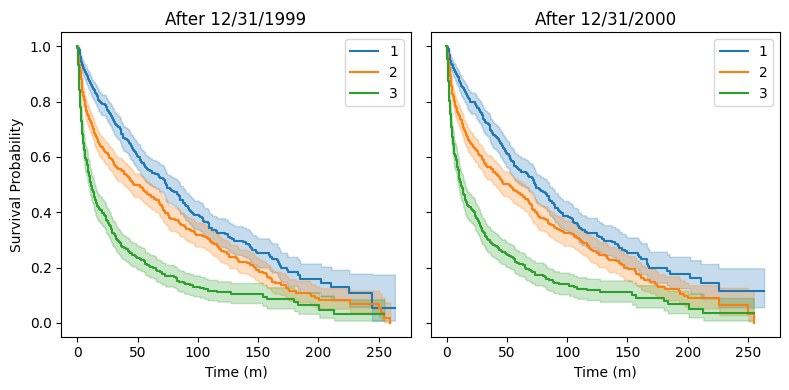

In [93]:
from lifelines import KaplanMeierFitter

date_ends = ["12/31/1999","12/31/2000"]

fig,axes = plt.subplots(1, len(date_ends), figsize=(4*len(date_ends),4), sharey=True)

for idx,date_end in enumerate(date_ends):
    kmf = KaplanMeierFitter()
    
    for clust in np.unique(data_df["cluster"].dropna()):
        _data_df = data_df[data_df["cluster"]==clust]
        _data_df = _data_df[_data_df["Date of admission to center"] >= date_end]

        _data_df['time'] = _data_df[['Date of death','Date of last visit']].max(axis=1) - _data_df['Date of admission to center']
        _data_df['time'] = _data_df['time'] / pd.Timedelta(days=30)

        kmf.fit(durations = _data_df["time"], event_observed = _data_df["status"], label=clust)
        kmf.plot_survival_function(ax=axes[idx])

        axes[idx].set_title("After {}".format(date_end))
        axes[idx].set_xlabel("Time (m)")
        axes[idx].set_ylabel("Survival Probability")

plt.tight_layout()

In [115]:
kmf.plot_survival_function?

Signature: kmf.plot_survival_function(**kwargs)
Docstring: Alias of ``plot``
File:      ~/anaconda3/envs/r4/lib/python3.10/site-packages/lifelines/fitters/kaplan_meier_fitter.py
Type:      method

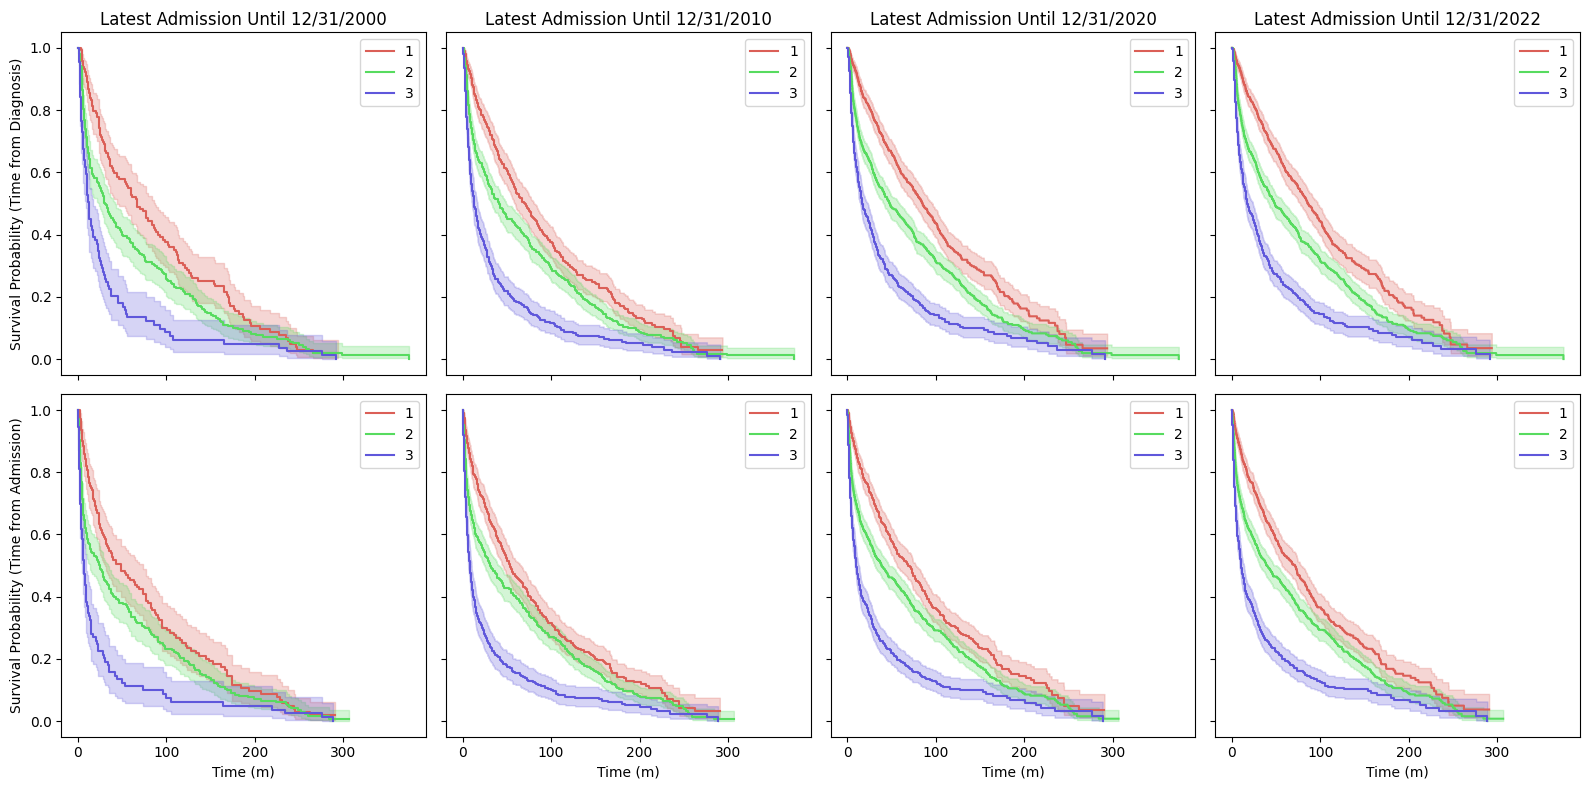

In [117]:
from lifelines import KaplanMeierFitter

date_ends = ["12/31/2000","12/31/2010", "12/31/2020", "12/31/2022"]

fig,axes = plt.subplots(2, len(date_ends), figsize=(4*len(date_ends),8), sharey=True, sharex=True)

for idx,date_end in enumerate(date_ends):
    kmf = KaplanMeierFitter()
    
    for idx_c, clust in enumerate(np.unique(data_df["cluster"].dropna())):
        _data_df = data_df[data_df["cluster"]==clust]
        _data_df = _data_df[_data_df["Date of admission to center"] <= date_end]

        kmf.fit(durations = _data_df["time"], event_observed = _data_df["status"], label=clust)
        kmf.plot_survival_function(ax=axes[0,idx], c=sns.color_palette("hls",3)[idx_c])

        axes[0,idx].set_title("Latest Admission Until {}".format(date_end))
        axes[0,idx].set_xlabel("Time (m)")
        axes[0,idx].set_ylabel("Survival Probability (Time from Diagnosis)")

        # Fixed TTE
        kmf.fit(durations = _data_df["time_from_admission"], event_observed = _data_df["status"], label=clust)
        kmf.plot_survival_function(ax=axes[1,idx], c=sns.color_palette("hls",3)[idx_c])

        axes[1,idx].set_xlabel("Time (m)")
        axes[1,idx].set_ylabel("Survival Probability (Time from Admission)")

plt.tight_layout()
plt.savefig("figures/TTE_by_cutoff.pdf", dpi=300, bbox_inches="tight")

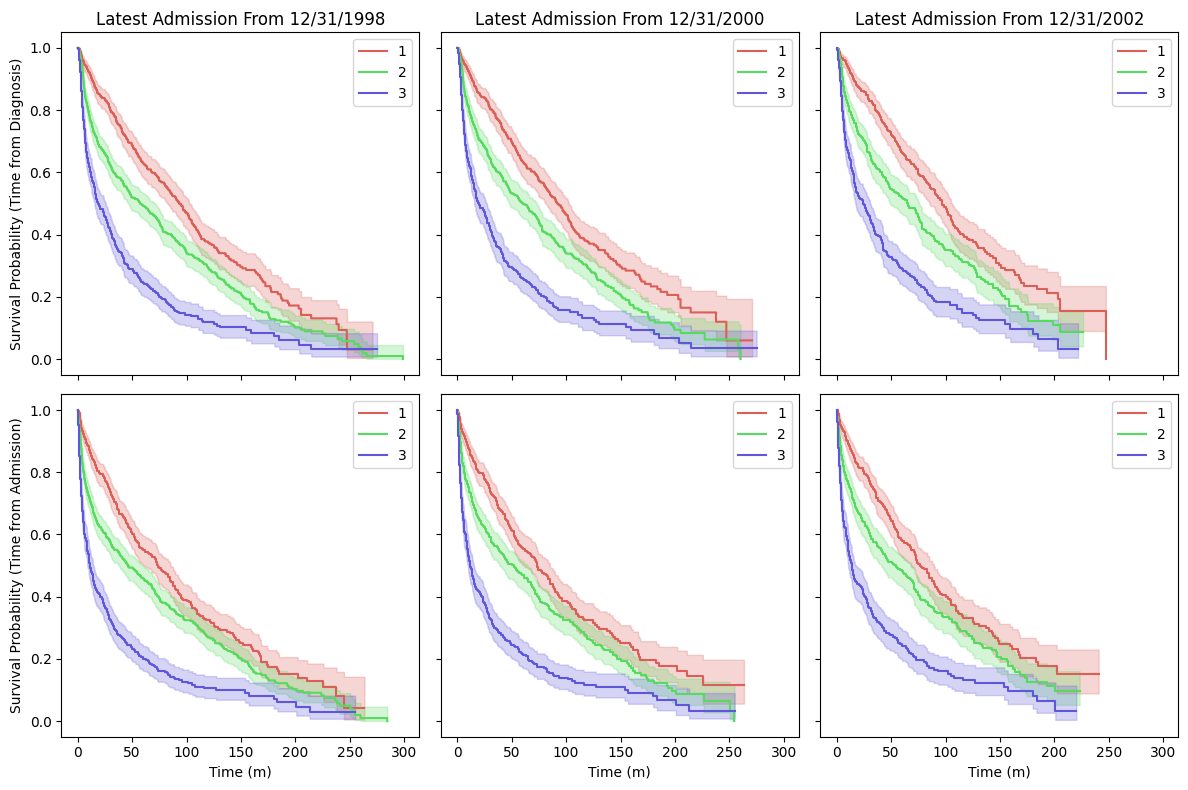

In [118]:
from lifelines import KaplanMeierFitter

date_ends = ["12/31/1998","12/31/2000", "12/31/2002"]

fig,axes = plt.subplots(2, len(date_ends), figsize=(4*len(date_ends),8), sharey=True, sharex=True)

for idx,date_end in enumerate(date_ends):
    kmf = KaplanMeierFitter()
    
    for idx_c, clust in enumerate(np.unique(data_df["cluster"].dropna())):
        _data_df = data_df[data_df["cluster"]==clust]
        _data_df = _data_df[_data_df["Date of admission to center"] >= date_end]

        kmf.fit(durations = _data_df["time"], event_observed = _data_df["status"], label=clust)
        kmf.plot_survival_function(ax=axes[0,idx], c=sns.color_palette("hls",3)[idx_c])

        axes[0,idx].set_title("Latest Admission From {}".format(date_end))
        axes[0,idx].set_xlabel("Time (m)")
        axes[0,idx].set_ylabel("Survival Probability (Time from Diagnosis)")

        # Fixed TTE
        kmf.fit(durations = _data_df["time_from_admission"], event_observed = _data_df["status"], label=clust)
        kmf.plot_survival_function(ax=axes[1,idx], c=sns.color_palette("hls",3)[idx_c])

        axes[1,idx].set_xlabel("Time (m)")
        axes[1,idx].set_ylabel("Survival Probability (Time from Admission)")

plt.tight_layout()
plt.savefig("figures/TTE_by_cutoff_from.pdf", dpi=300, bbox_inches="tight")

In [119]:
# from lifelines import KaplanMeierFitter

# # Landmark Analysis
# times = [2,6,9,12,24]

# fig,axes = plt.subplots(1, len(times), figsize=(4*len(times),4), sharey=True)

# for idx,time in enumerate(times):
#     kmf = KaplanMeierFitter()

#     _data_df = data_df[data_df["time"] >= time]

#     # Landmark time
#     _data_df.loc[:,"time"] = _data_df["time"] - time
    
#     for clust in np.unique(_data_df["cluster"].dropna()):
#         _data_clust_df = _data_df[_data_df["cluster"]==clust]

#         kmf.fit(durations = _data_clust_df["time"], event_observed = _data_clust_df["status"], label=clust)
#         kmf.plot_survival_function(ax=axes[idx])

#         axes[idx].set_title("Landmark T={} (m)".format(time))
#         axes[idx].set_xlabel("Time (m)")
#         axes[idx].set_ylabel("Survival Probability")

# plt.tight_layout()
# plt.savefig("figures/TTE_by_landmark_time.pdf", dpi=300, bbox_inches="tight")

In [123]:
# Generate outcome 
y = Xi_mice_bu_df.loc[:,['status','time']]
y.loc[:,'status'] = y['status'].replace({1:True,0:False})
y = np.array(list(y.to_records(index=False)))

# Split data
X_train, X_test, y_train, y_test = train_test_split(Xi_mice_bu_df.drop(columns=['time','status']), y, test_size=test_size, random_state=RANDOM_STATE)

print("Train size (n={})".format(X_train.shape[0]))
print("Test size (n={})".format(X_test.shape[0]))

Train size (n=1200)
Test size (n=401)


#### 2a. Baseline Cox Regression Models
---

In [124]:
# Cox Model #1
# Surv ~ Age + Sex + Race + Primary Organ + Troponin + BU Stage
numerical_vars = ["Age","eGFR","Troponin"]
categorical_vars = ["Sex","Race","Primary organ","BU Stage (Computed)"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph"] = CoxPHSurvivalAnalysis()
models["cph"].fit(X_train[vars_to_use], y_train)

# Cox Model #2
# Surv ~ Age + Sex + Race + Primary Organ + Troponin + BU Stage + cluster
numerical_vars = ["Age","eGFR","Troponin"]
categorical_vars = ["Sex","Race","Primary organ","BU Stage (Computed)","cluster"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph2"] = CoxPHSurvivalAnalysis()
models["cph2"].fit(X_train[vars_to_use], y_train)

# Cox Model #3
# Surv ~ BU Stage
numerical_vars = []
categorical_vars = ["BU Stage (Computed)"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph3"] = CoxPHSurvivalAnalysis()
models["cph3"].fit(X_train[vars_to_use], y_train)

CoxPHSurvivalAnalysis()

#### 2b. Random Survival Forest
---

In [125]:
cluster_vars = []

for x in X_train.columns:
    if "BU" in x or "cluster" in x:
        cluster_vars.append(x)

cluster_vars

['cluster=2',
 'cluster=3',
 'BU Stage (Computed)=stage II',
 'BU Stage (Computed)=stage III',
 'BU Stage (Computed)=stage IIIb']

In [126]:
# Initial RSF model, no hyperparameter search
models["rsf"] = RandomSurvivalForest(
    n_estimators=10, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=RANDOM_STATE
)

# Fit Model
models["rsf"].fit(X_train.drop(columns=cluster_vars), y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_estimators=10,
                     n_jobs=-1, random_state=122)

### 2c. Prediction for Time to Admission
---

In [145]:
Xi_mice_bu_filt_df = Xi_mice_bu_df.join(data_df["time_from_admission"])
Xi_mice_bu_filt_df = Xi_mice_bu_filt_df[Xi_mice_bu_filt_df["time_from_admission"]>0]

In [146]:
# Generate outcome 
y = Xi_mice_bu_filt_df.loc[:,['status','time_from_admission']]
y.loc[:,'status'] = y['status'].replace({1:True,0:False})
y = np.array(list(y.to_records(index=False)))

# Split data
X_train_admission, X_test_admission, y_train_admission, y_test_admission = train_test_split(Xi_mice_bu_filt_df.drop(columns=['time','time_from_admission','status']), y, test_size=test_size, random_state=RANDOM_STATE)

print("Train size (n={})".format(X_train_admission.shape[0]))
print("Test size (n={})".format(X_test_admission.shape[0]))

Train size (n=1051)
Test size (n=351)


In [147]:
# Cox Model #1
# Surv ~ Age + Sex + Race + Primary Organ + Troponin + BU Stage
numerical_vars = ["Age","eGFR","Troponin"]
categorical_vars = ["Sex","Race","Primary organ","BU Stage (Computed)"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph_admission"] = CoxPHSurvivalAnalysis()
models["cph_admission"].fit(X_train_admission[vars_to_use], y_train_admission)

# Cox Model #2
# Surv ~ Age + Sex + Race + Primary Organ + Troponin + BU Stage + cluster
numerical_vars = ["Age","eGFR","Troponin"]
categorical_vars = ["Sex","Race","Primary organ","BU Stage (Computed)","cluster"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph2_admission"] = CoxPHSurvivalAnalysis()
models["cph2_admission"].fit(X_train_admission[vars_to_use], y_train_admission)

# Cox Model #3
# Surv ~ BU Stage
numerical_vars = []
categorical_vars = ["BU Stage (Computed)"]
categorical_vars = list(chain(*[Xi_mice_bu_df.columns[Xi_mice_bu_df.columns.str.startswith(cat)] for cat in categorical_vars]))
vars_to_use = numerical_vars + categorical_vars

# Fit Cox Regression
models["cph3_admission"] = CoxPHSurvivalAnalysis()
models["cph3_admission"].fit(X_train_admission[vars_to_use], y_train_admission)

CoxPHSurvivalAnalysis()

In [148]:
# Initial RSF model, no hyperparameter search
models["rsf_admission"] = RandomSurvivalForest(
    n_estimators=10, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=RANDOM_STATE
)

# Fit Model
models["rsf_admission"].fit(X_train_admission.drop(columns=cluster_vars), y_train_admission)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_estimators=10,
                     n_jobs=-1, random_state=122)

### 3. Comparing Model Performance
---

In [149]:
for key, _ in models.items():
    if "_admission" in key:
        # Predictions on Test Set
        print("Results for: model {}".format(key))
        print("  * C-statistic (Train): ", models[key].score(X_train_admission.loc[:,models[key].feature_names_in_], y_train_admission))
        print("  * C-statistic (Test): ", models[key].score(X_test_admission.loc[:,models[key].feature_names_in_], y_test_admission))

        # Predictions
        risk_scores[key] = models[key].predict(X_test_admission.loc[:,models[key].feature_names_in_])
        aucs[key], mean_aucs[key] = cumulative_dynamic_auc(y_train_admission, y_test_admission, risk_scores[key], x_times)
    else:
        # Predictions on Test Set
        print("Results for: model {}".format(key))
        print("  * C-statistic (Train): ", models[key].score(X_train.loc[:,models[key].feature_names_in_], y_train))
        print("  * C-statistic (Test): ", models[key].score(X_test.loc[:,models[key].feature_names_in_], y_test))

        # Predictions
        risk_scores[key] = models[key].predict(X_test.loc[:,models[key].feature_names_in_])
        aucs[key], mean_aucs[key] = cumulative_dynamic_auc(y_train, y_test, risk_scores[key], x_times)

Results for: model cph
  * C-statistic (Train):  0.7033329440717625
  * C-statistic (Test):  0.6906285667699331
Results for: model cph2
  * C-statistic (Train):  0.7120264524863001
  * C-statistic (Test):  0.702735203000163
Results for: model cph3
  * C-statistic (Train):  0.652424018303944
  * C-statistic (Test):  0.6436389205935105
Results for: model rsf
  * C-statistic (Train):  0.814531999463684
  * C-statistic (Test):  0.7247676504157835
Results for: model cph_admission
  * C-statistic (Train):  0.6784388375760306
  * C-statistic (Test):  0.7098329189024124
Results for: model cph2_admission
  * C-statistic (Train):  0.685440414507772
  * C-statistic (Test):  0.721742354840117
Results for: model cph3_admission
  * C-statistic (Train):  0.6381685064203649
  * C-statistic (Test):  0.6642891419098722
Results for: model rsf_admission
  * C-statistic (Train):  0.7967931966659157
  * C-statistic (Test):  0.7393883872093531


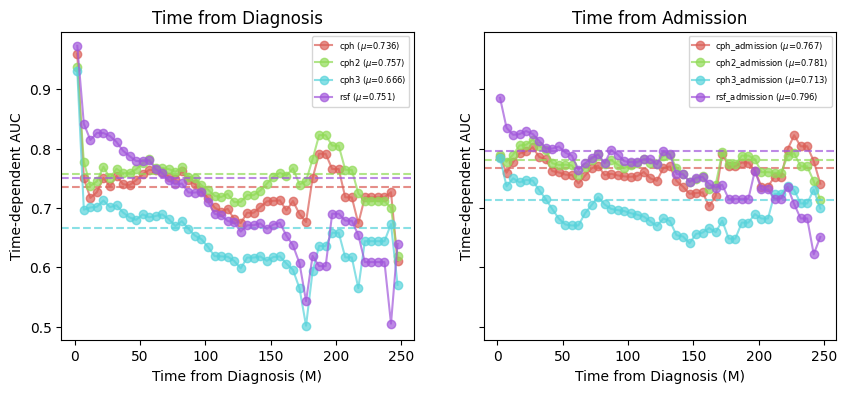

In [160]:
fig, axes = plt.subplots(1,2,figsize=(10,4), sharey=True)

colors = sns.color_palette("hls",4)
for idx,key in enumerate(["cph","cph2","cph3","rsf"]):
    axes[0].plot(x_times, aucs[key], marker="o", c=colors[idx], label="{} ($\mu$={:.3})".format(key, mean_aucs[key]), alpha=0.7)
    axes[0].axhline(mean_aucs[key], linestyle="--", c=colors[idx], alpha=0.7)

axes[0].set_xlabel("Time from Diagnosis (M)")
axes[0].set_ylabel("Time-dependent AUC")
#ax.grid(True)
axes[0].legend(fontsize=6)

for idx,key in enumerate(["cph_admission","cph2_admission","cph3_admission","rsf_admission"]):
    axes[1].plot(x_times, aucs[key], marker="o", c=colors[idx], label="{} ($\mu$={:.3})".format(key, mean_aucs[key]), alpha=0.7)
    axes[1].axhline(mean_aucs[key], linestyle="--", c=colors[idx], alpha=0.7)

axes[1].set_xlabel("Time from Diagnosis (M)")
axes[1].set_ylabel("Time-dependent AUC")
axes[1].legend(fontsize=6)
axes[0].set_title("Time from Diagnosis")
axes[1].set_title("Time from Admission")

plt.savefig("figures/test_timedep_auc_plot_comp.pdf", dpi=200, bbox_inches="tight")

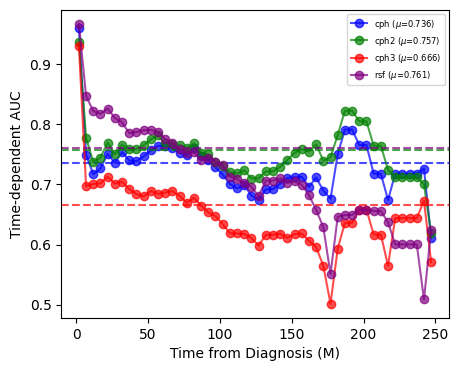

In [53]:
fig, ax = plt.subplots(figsize=(5,4))

colors = ["b","g","r","purple"]

for idx,(key, _) in enumerate(models.items()):
    ax.plot(x_times, aucs[key], marker="o", c=colors[idx], label="{} ($\mu$={:.3})".format(key, mean_aucs[key]), alpha=0.7)
    ax.axhline(mean_aucs[key], linestyle="--", c=colors[idx], alpha=0.7)

ax.set_xlabel("Time from Diagnosis (M)")
ax.set_ylabel("Time-dependent AUC")
#ax.grid(True)
ax.legend(fontsize=6)

plt.savefig("figures/test_timedep_auc_plot.pdf", dpi=200, bbox_inches="tight")

### 4. Feature Importance to Survival
---

In [58]:
import shap
from tqdm import tqdm

shap_explainers = dict()
shap_values = dict()

In [59]:
for key,_ in tqdm(models.items()):
    shap_explainers[key] = shap.Explainer(models[key].predict, X_train.loc[:,models[key].feature_names_in_])
    shap_values[key] = shap_explainers[key](X_test.loc[:,models[key].feature_names_in_])

PermutationExplainer explainer: 402it [00:15, 10.76it/s]                         
PermutationExplainer explainer: 402it [00:12,  5.48it/s]                         
PermutationExplainer explainer: 402it [14:01,  2.12s/it]
100%|██████████| 4/4 [14:30<00:00, 217.72s/it]


In [75]:
X_tes

,Sex=male,Ethnicity=non_hispanic,Race=Black,Race=Other,Race=White,Kappa or lambda PCD=L,Primary organ=cardiac,Primary organ=gi,Primary organ=hepatic,Primary organ=other,...,Troponin,Calcium,Uric acid,LDH,Iron,TIBC,Systolic BP sitting,Diastolic BP sitting,Pulse sitting,Age
2021142,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.039,9.0,3.8,255,68,218,137,81,63,75
2017149,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.324,10.0,7.4,223,95,277,112,75,82,60
2020060,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.049,9.6,8.7,239,31,251,185,62,73,76
2007082,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.350,9.0,5.7,332,21,336,128,76,60,59
2001049,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.163,8.5,5.8,279,86,210,136,86,86,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006117,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.138,9.9,4.6,154,46,284,159,95,91,59
2018006,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.020,10.3,5.3,219,135,317,137,82,66,74
2011055,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.045,9.8,3.2,267,25,361,102,71,98,52
98075,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.065,9.3,10.0,168,51,309,133,84,64,63


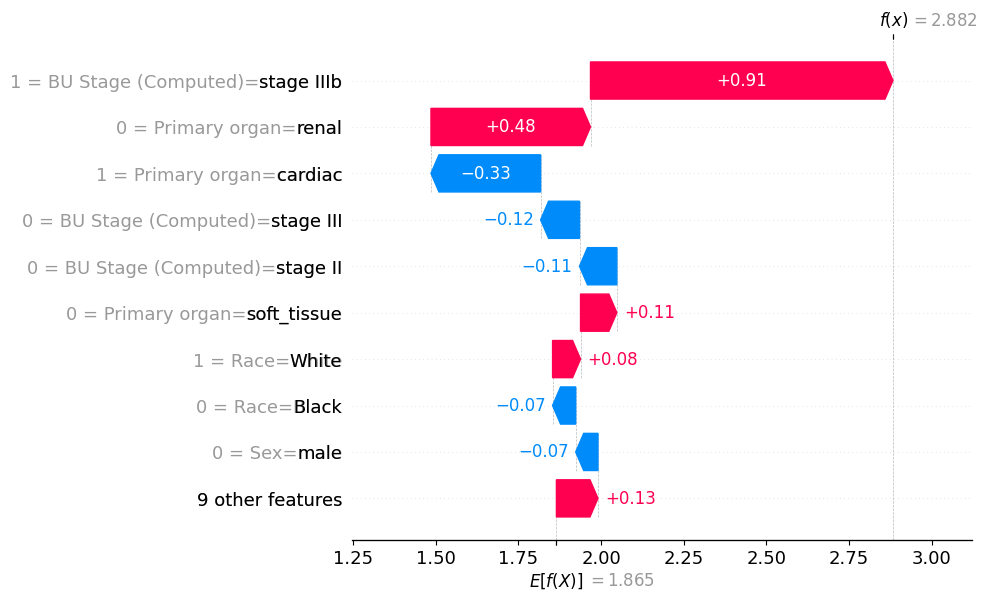

In [76]:
shap.plots.waterfall(shap_values["cph"][3])

In [83]:
shap.plots.beeswarm

<function shap.plots._beeswarm.beeswarm(shap_values, max_display=10, order=shap.Explanation.abs.mean(0), clustering=None, cluster_threshold=0.5, color=None, axis_color='#333333', alpha=1, show=True, log_scale=False, color_bar=True, plot_size='auto', color_bar_label='Feature value')>

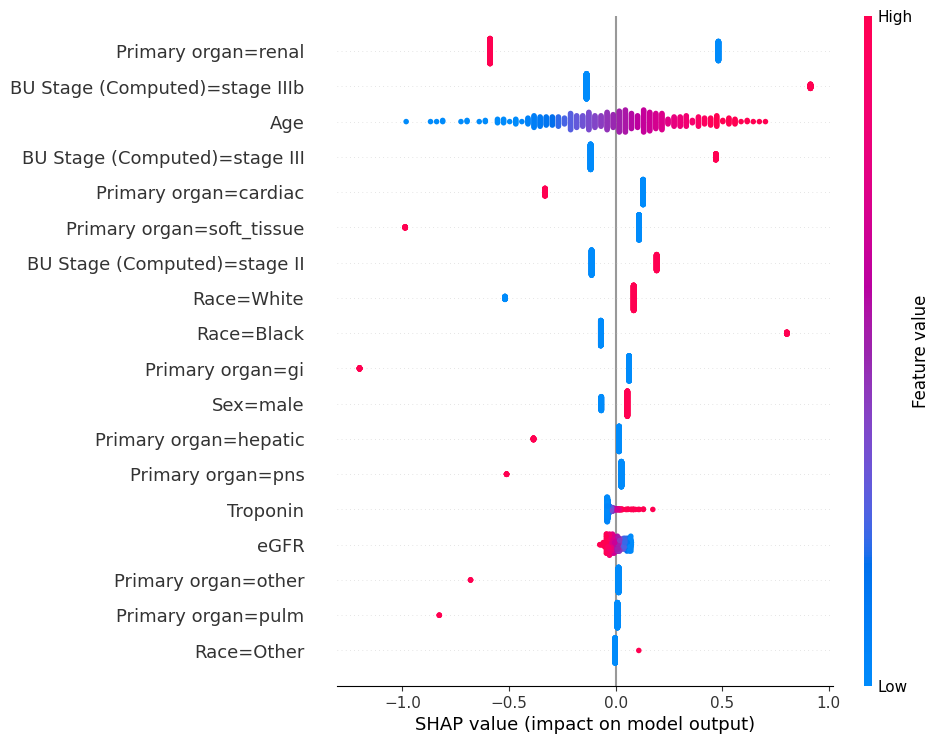

In [84]:
shap.plots.beeswarm(shap_values["cph"], show=False, max_display=30)
plt.savefig("figures/cph1_beeswarm_test.pdf", dpi=200, bbox_inches="tight")

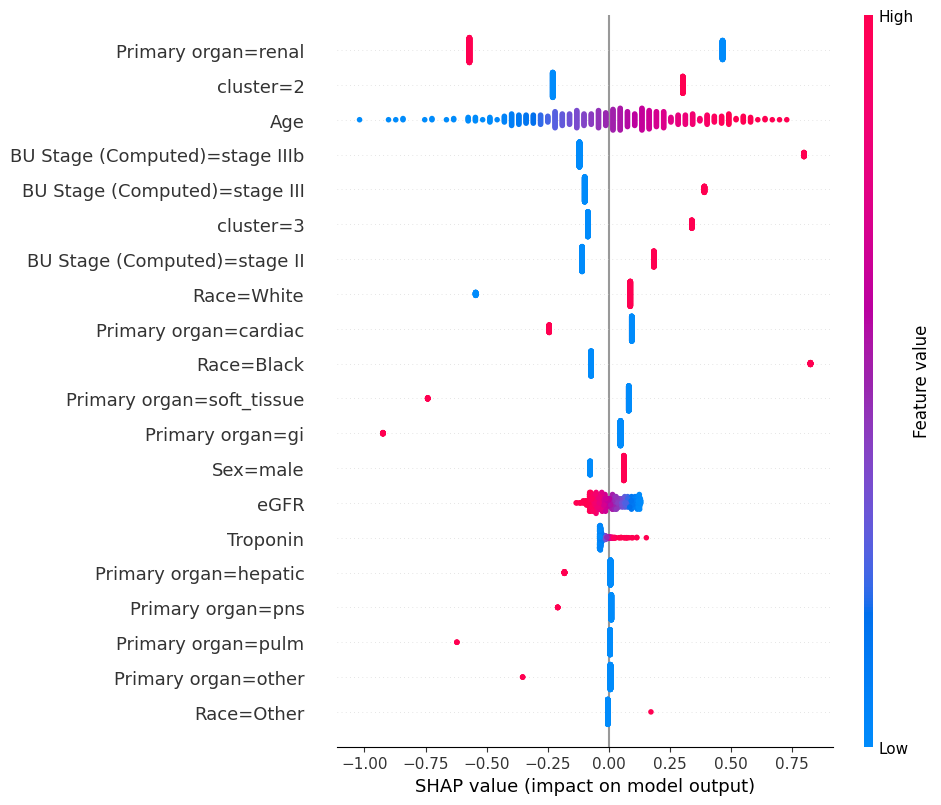

In [85]:
shap.plots.beeswarm(shap_values["cph2"], show=False, max_display=30)
plt.savefig("figures/cph2_beeswarm_test.pdf", dpi=200, bbox_inches="tight")

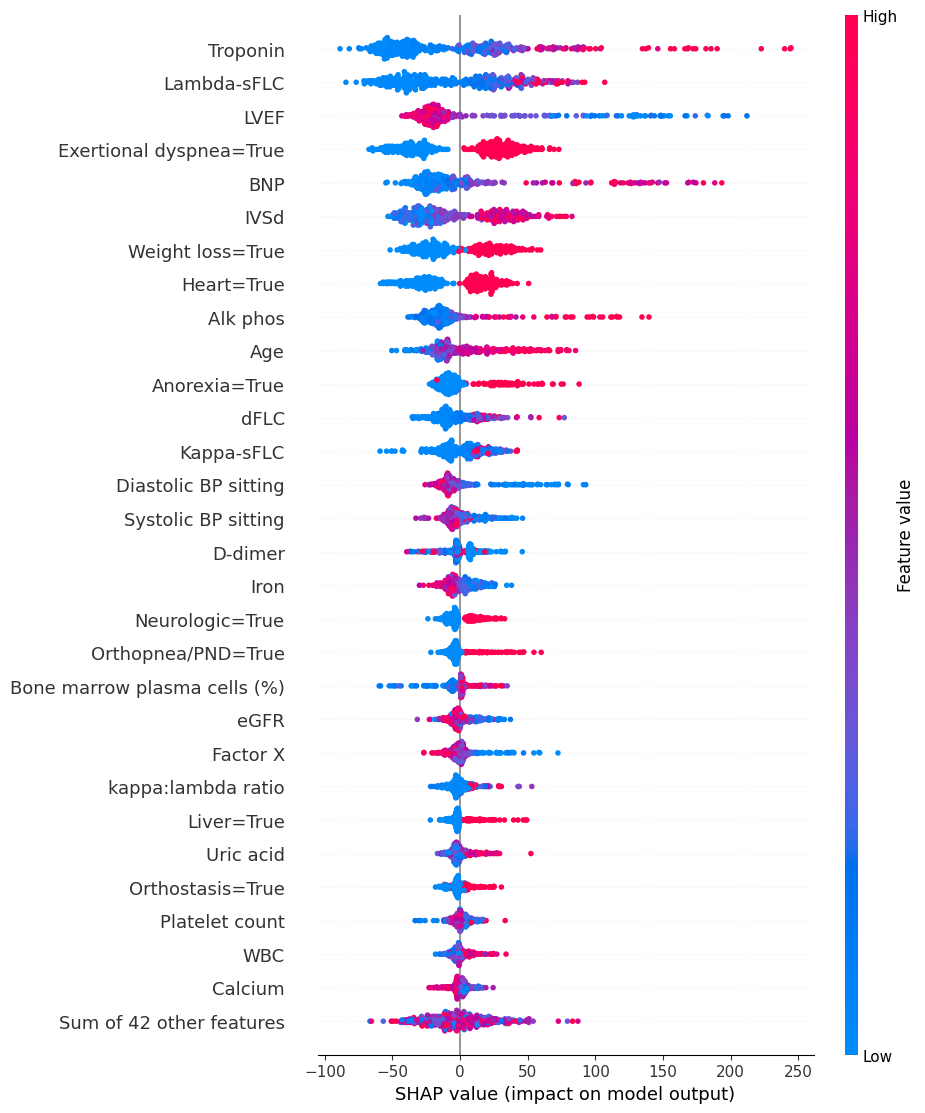

In [86]:
shap.plots.beeswarm(shap_values["rsf"], show=False, max_display=30)
plt.savefig("figures/rsf_beeswarm_test.pdf", dpi=200, bbox_inches="tight")

In [33]:
import importlib; importlib.reload(utils)

df = utils.compute_permutation_importance(rsf, X_test.loc[:,rsf.feature_names_in_], y_test, random_state=RANDOM_STATE)

In [48]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
#explainer = shap.Explainer(rsf.predict, X_train.drop(columns=cluster_vars))
#shap_values = explainer(X_test.drop(columns=cluster_vars))
#shap.Explainer(model_rvr.predict, X)

In [ ]:
shap.plots.beeswarm(

In [51]:
shap.plots.beeswarm

<function shap.plots._beeswarm.beeswarm(shap_values, max_display=10, order=shap.Explanation.abs.mean(0), clustering=None, cluster_threshold=0.5, color=None, axis_color='#333333', alpha=1, show=True, log_scale=False, color_bar=True, plot_size='auto', color_bar_label='Feature value')>

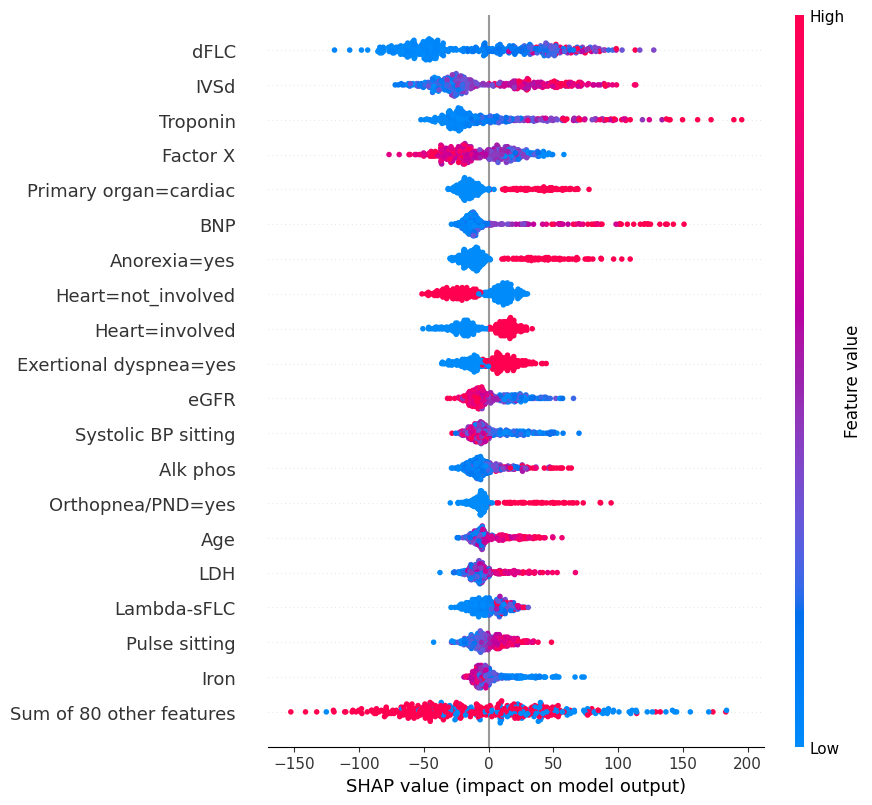

In [52]:
shap.plots.beeswarm(shap_values, max_display=20)

In [20]:
# class DataObject(object):
#     """_summary_

#     Args:
#         object (_type_): _description_
#     """
#     def __init__(self, X: pd.DataFrame, time: str = "time", indicator: str = "status") -> None:
#         """_summary_

#         Args:
#             X (pd.DataFrame): _description_
#             time (str, optional): _description_. Defaults to "time".
#             indicator (str, optional): _description_. Defaults to "status".
#         """
#         from sksurv.preprocessing import OneHotEncoder

#         self.X = X

#         # Select numeric and categorical variables
#         self.X_cat = self.X.loc[:, self.X.dtypes in ["object","category"]].astype("category")
#         self.X_numeric = self.X.loc[:, self.X.dtypes not in  ["object","category"]]

#         # One hot encode categorical variables
#         self.X_cat_onehot = OneHotEncoder().fit_transform(self.X_cat)

#     def __str__(self) -> str:
#         print("Data Object \n \t * {} nategorical variables \n \t * {} numeric variables".format(
#             self.X_cat.shape[0], self.X_numeric.shape[0]))
        
# DataObject(test_df)